# 타이타닉 생존자 예측
- 데이터 확인
- 결손치 처리
- 문자열 처리
- Survived 속성을 y로 나머지 피쳐를 x로 만듦
- 학습/테스트 데이터 세트 분리
- 적용할 알고리즘 선정:
    - DecisionTreeClassifier / RandomForestClassifier / LogisticRegression
- 학습, 예측 및 평가
- 교차 검증
- GridSearchCV를 통해 최적 파라미터 도출출

### 1. 설치

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('### train 데이터 정보 ###  \n')
print(titanic_df.info())

### train 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Null/Nan 처리

In [4]:
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 불필요한 컬럼 삭제

In [5]:
del titanic_df['PassengerId']
titanic_df.drop('Name', axis=1, inplace=True)
titanic_df.drop(['Ticket','Cabin'], axis=1, inplace=True)

In [6]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


- Nan 처리

In [7]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 갯수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 갯수  0


In [8]:
print('Sex 값 분포 :\n', titanic_df['Sex'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64


In [9]:
print('Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


### 데이터 탐색

In [10]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

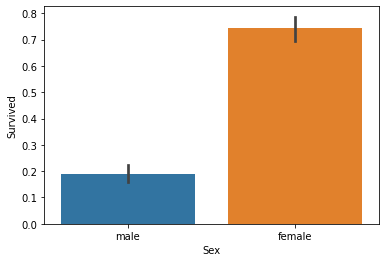

In [11]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df);

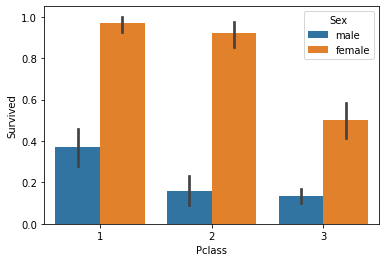

In [12]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df);

In [13]:
# 입력 age에 따라 구분값을 반환하는 함수. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= 5: 
        cat = 'Baby'
    elif age <= 12: 
        cat = 'Child'
    elif age <= 18: 
        cat = 'Teenager'
    elif age <= 25: 
        cat = 'Student'
    elif age <= 35: 
        cat = 'Young Adult'
    elif age <= 60: 
        cat = 'Adult'
    else: 
        cat = 'Elderly'
    
    return cat

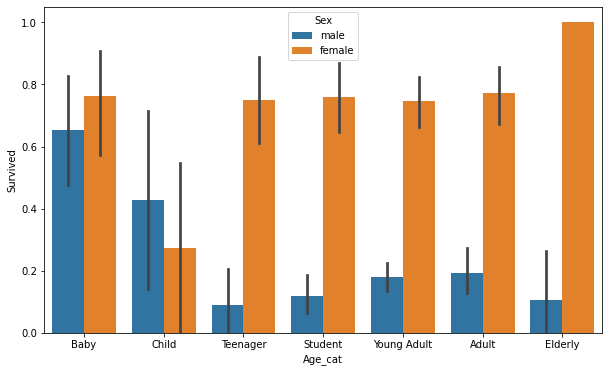

In [14]:
# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

### 데이터 전처리

In [15]:
from sklearn.preprocessing import LabelEncoder

features = ['Sex', 'Embarked']
for feature in features:
    le = LabelEncoder()
    titanic_df[feature] = le.fit_transform(titanic_df[feature])

titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,3
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,3
3,1,1,0,35.0,1,0,53.1000,3
4,0,3,1,35.0,0,0,8.0500,3


- 데이터 전처리에 필요한 함수

In [16]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    features = ['Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

### 생존자 예측 수행

In [18]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_titanic_df, y_titanic_df, stratify=y_titanic_df,
    test_size=0.2, random_state=2021
)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [21]:
import warnings
warnings.filterwarnings(action='ignore')

In [22]:
# DecisionTreeClassifier 학습/예측/평가
dt_clf = DecisionTreeClassifier(random_state=2021)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print(f'DecisionTreeClassifier 정확도: {accuracy_score(y_test, dt_pred):.4f}')

# RandomForestClassifier 학습/예측/평가
rf_clf = RandomForestClassifier(random_state=2021)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print(f'RandomForestClassifier 정확도:{accuracy_score(y_test, rf_pred):.4f}')

# LogisticRegression 학습/예측/평가
lr_clf = LogisticRegression(random_state=2021)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print(f'LogisticRegression 정확도: {accuracy_score(y_test, lr_pred):.4f}')

# SupportVectorClassifier 학습/예측/평가
sv_clf = SVC(random_state=2021)
sv_clf.fit(X_train, y_train)
sv_pred = sv_clf.predict(X_test)
print(f'SupportVectorClassifier 정확도: {accuracy_score(y_test, sv_pred):.4f}')

DecisionTreeClassifier 정확도: 0.7374
RandomForestClassifier 정확도:0.8101
LogisticRegression 정확도: 0.7709
SupportVectorClassifier 정확도: 0.7039


### 교차검증

- 결정트리모델을 cross_val_score 함수에 적용

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
print(scores)
print(f"결정 트리 평균 정확도: {np.mean(scores):.4f}")

[0.74860335 0.76966292 0.78651685 0.74157303 0.80898876]
결정 트리 평균 정확도: 0.7711


In [24]:
# RandomForestClassifier 
scores = cross_val_score(rf_clf, X_titanic_df, y_titanic_df, cv=5)
print(scores)
print(f"RandomForestClassifier 평균 정확도: {np.mean(scores):.4f}")

# LogisticRegression 
scores = cross_val_score(lr_clf, X_titanic_df, y_titanic_df, cv=5)
print(scores)
print(f"LogisticRegression 평균 정확도: {np.mean(scores):.4f}")

# SupportVectorClassifier
scores = cross_val_score(sv_clf, X_titanic_df, y_titanic_df, cv=5)
print(scores)
print(f"SupportVectorClassifier 평균 정확도: {np.mean(scores):.4f}")

[0.79329609 0.81460674 0.86516854 0.76966292 0.83707865]
RandomForestClassifier 평균 정확도: 0.8160
[0.78212291 0.78651685 0.78089888 0.76404494 0.82022472]
LogisticRegression 평균 정확도: 0.7868
[0.59776536 0.71348315 0.69101124 0.68539326 0.69101124]
SupportVectorClassifier 평균 정확도: 0.6757


### GridSearchCV를 통하여 결정트리 모델의 최적 파라미터 도출

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth':[2,3,5,8],
    'min_samples_leaf':[2,5,8],
    'min_samples_split':[2,3,5,8] 
}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, 
                         scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'max_depth': [2, 3, 5, 8],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2, 3, 5, 8]},
             scoring='accuracy')

In [26]:
grid_dclf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [27]:
parameters = {
    'max_depth':[4,5,6,7],
    'min_samples_leaf':[3,4,5,6,7],
    'min_samples_split':[2,3] 
}
grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, 
                         scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2021),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'min_samples_leaf': [3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3]},
             scoring='accuracy')

In [28]:
grid_dclf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [29]:
print(f'GridSearchCV 최고 정확도: {grid_dclf.best_score_:.4f}')

GridSearchCV 최고 정확도: 0.8161


In [30]:
# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
best_dclf = grid_dclf.best_estimator_
pred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'테스트 세트에서의 DecisionTreeClassifier 정확도: {accuracy:.4f}')

테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8156


### 타이타닉 엉터리 분류기

In [31]:
from sklearn.base import BaseEstimator
class MyClassifier(BaseEstimator):
    # fit(), predict() method에 대해서 재정의(overriding)
    def fit(self, X, y):
        pass
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 0:   # i 가 index가 아니라 X['Sex'][i] 는 에러
                pred[i, 0] = 1
        return pred

In [32]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
25,3,0,38.000000,1,5,31.3875,3
692,3,1,29.699118,0,0,56.4958,3
435,1,0,14.000000,1,2,120.0000,3
413,2,1,29.699118,0,0,0.0000,3
654,3,0,18.000000,0,0,6.7500,2


In [33]:
X_test['Sex'][25]

0

In [34]:
my_clf = MyClassifier()
my_clf.fit(X_train, y_train)
pred = my_clf.predict(X_test)
accuracy_score(y_test, pred)

0.7877094972067039